# recurrent neural network (RNN) + Cys

In [1]:
import json
import os
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

2.0.0+cu117
1.26.4


In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)

## without Cys

In [78]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep notCys
select = df11[0].apply(lambda x: False if 'C' in x else True)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
df21 = df21.sample(frac=.5)
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
df31 = df31.sample(frac=.4)
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
True     1639058
False     226184
Name: count, dtype: int64
(1639058, 2)
(3185991, 2) (1592996, 2)
(1863999, 2) (745599, 2)


In [79]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(3977653, 2)


,0,1
666283,PTFVLSITA,other
1682736,PAGERFPMQGLYNAM,random
195207,KLAMLTGVLL,epitope
1307428,GGNNSEDAEDE,other
351979,HTKSSKWVF,other


In [80]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'PTFVLSITA')
Counter({'epitope': 1639058, 'other': 1592996, 'random': 745599})


In [81]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('random', 'PRECATMRAPPSLAVG')
split data:  2386591 795530 795532

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: YRVLTSEQK ['Y', 'R', 'V', 'L', 'T', 'S', 'E', 'Q', 'K']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 2478442), ('A', 2080646), ('S', 2051734), ('E', 1892222), ('G', 1866880), ('V', 1820591), ('K', 1667139), ('P', 1654983), ('T', 1583807), ('R', 1553444), ('D', 1469425), ('I', 1391919), ('Q', 1322858), ('N', 1196689), ('F', 1156861), ('Y', 981430), ('H', 832827), ('M', 738868), ('W', 551143), ('C', 541573), ('X', 1573), ('U', 30), ('Z', 21), ('B', 19), ('J', 2)])
counts of input: [983632, 955573, 447386]

## Step 3 encoding: encoding each unique token into integers...


In [82]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [83]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.7925 val_acc: 0.8023, val_recall: 0.8058
Epoch 1 acc: 0.8048 val_acc: 0.8062, val_recall: 0.8061
Epoch 2 acc: 0.8084 val_acc: 0.8074, val_recall: 0.8072
Epoch 3 acc: 0.8101 val_acc: 0.8089, val_recall: 0.8081
Epoch 4 acc: 0.8118 val_acc: 0.8090, val_recall: 0.8115
Epoch 5 acc: 0.8129 val_acc: 0.8093, val_recall: 0.8130
Epoch 6 acc: 0.8141 val_acc: 0.8094, val_recall: 0.8106
Epoch 7 acc: 0.8151 val_acc: 0.8103, val_recall: 0.8124
Epoch 8 acc: 0.8154 val_acc: 0.8103, val_recall: 0.8071
Epoch 9 acc: 0.8167 val_acc: 0.8112, val_recall: 0.8119
Epoch 10 acc: 0.8170 val_acc: 0.8103, val_recall: 0.8113
Epoch 11 acc: 0.8175 val_acc: 0.8111, val_recall: 0.8102
Epoch 12 acc: 0.8176 val_acc: 0.8105, val_recall: 0.8096
Epoch 13 acc: 0.8183 val_acc: 0.8114, val_recall: 0.8124
Epoch 14 acc: 0.8185 val_acc: 0.8111, val_recall: 0.8134
Epoch 15 acc: 0.8187 val_acc: 0.8112, val_recall: 0.8152
Epoch 16 acc: 0.8192 val_acc: 0.8117, val_recall: 0.8115
Epoch 17 acc: 0.8196 val_acc: 0.8115, val

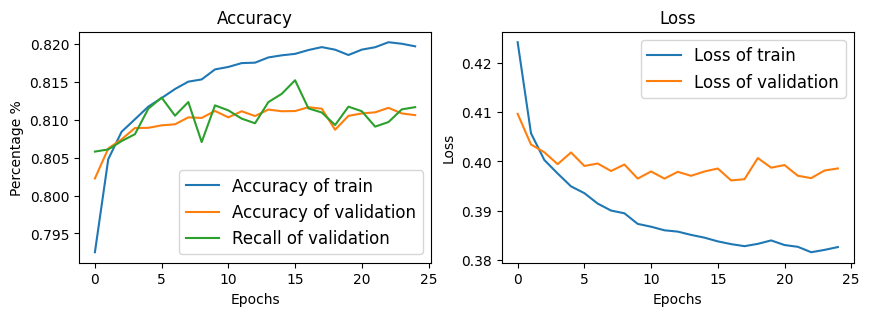

In [84]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [85]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8122975213256101,
 'accuracy': 0.8113300282075391,
 'loss': 0.3973080917900584}

In [86]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]

327456 468076


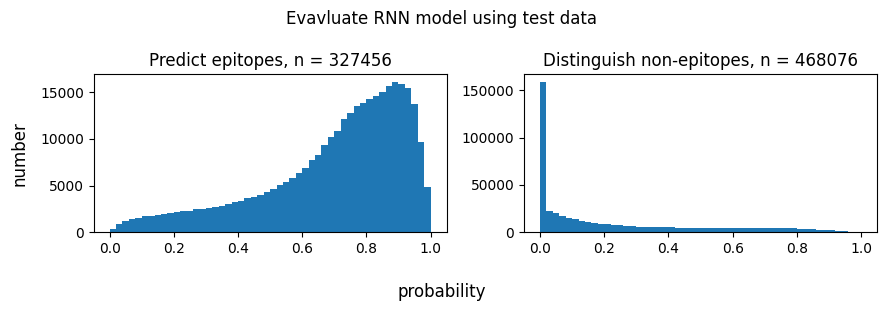

In [87]:
MyEvaluate.plot_prob(pred_test)

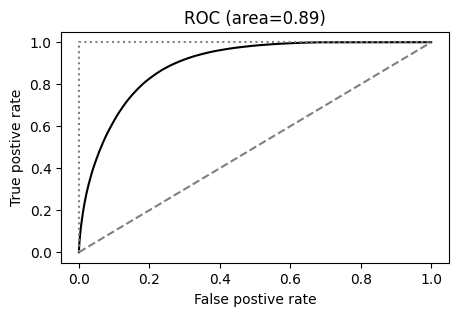

In [88]:
MyEvaluate.plot_roc(pred_test)

In [89]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_notcys.pth')

## has Cys

In [90]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep notCys
select = df11[0].apply(lambda x: True if 'C' in x else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

(1865242, 2) (1865242, 2)
0
False    1639058
True      226184
Name: count, dtype: int64
(226184, 2)


In [91]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)

(2564779, 2)


In [92]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('random', 'HHMTKAHYKGKFMPGMGKW')
Counter({'other': 1592996, 'random': 745599, 'epitope': 226184})


In [93]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('other', 'KNKGSDSSL')
split data:  1538867 512955 512957

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: NTMRLAEQGTIAIMK ['N', 'T', 'M', 'R', 'L', 'A', 'E', 'Q', 'G', 'T', 'I', 'A', 'I', 'M', 'K']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 1421372), ('S', 1240852), ('A', 1179116), ('G', 1166742), ('E', 1118372), ('V', 1060975), ('P', 1013416), ('K', 972366), ('R', 957215), ('T', 956080), ('D', 934988), ('I', 827419), ('Q', 824682), ('N', 766883), ('F', 725903), ('C', 709838), ('Y', 618897), ('H', 577665), ('M', 541050), ('W', 448107), ('X', 1694), ('U', 31), ('Z', 24), ('B', 14), ('J', 1)])
counts of input: [955403, 447332, 136132]

## Step 3 encoding: encoding each unique token into integers...


In [94]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [95]:
num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.9227 val_acc: 0.9264, val_recall: 0.6954
Epoch 1 acc: 0.9282 val_acc: 0.9301, val_recall: 0.7469
Epoch 2 acc: 0.9308 val_acc: 0.9314, val_recall: 0.7379
Epoch 3 acc: 0.9319 val_acc: 0.9313, val_recall: 0.7044
Epoch 4 acc: 0.9325 val_acc: 0.9318, val_recall: 0.7509
Epoch 5 acc: 0.9335 val_acc: 0.9330, val_recall: 0.7232
Epoch 6 acc: 0.9347 val_acc: 0.9340, val_recall: 0.7523
Epoch 7 acc: 0.9359 val_acc: 0.9347, val_recall: 0.7556
Epoch 8 acc: 0.9366 val_acc: 0.9345, val_recall: 0.7622
Epoch 9 acc: 0.9368 val_acc: 0.9342, val_recall: 0.7576


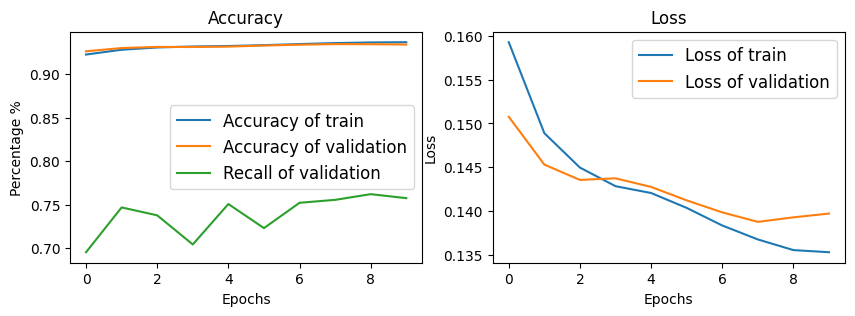

In [96]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [97]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7586150585120195,
 'accuracy': 0.9338365593997158,
 'loss': 0.1402063649204577}

In [98]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,LSNCTDIQVSFIERY,4.454023e-01,random
1,CRGILNEIKDRN,6.832862e-01,epitope
2,FGCLQTLKGVSL,6.832182e-01,random
3,AGQICELAD,8.060138e-03,other
4,EWHKNYPG,5.384969e-10,random


45164 467793


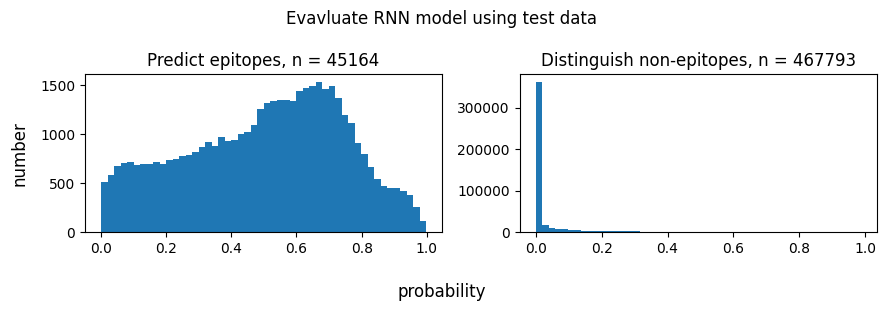

In [99]:
MyEvaluate.plot_prob(pred_test)

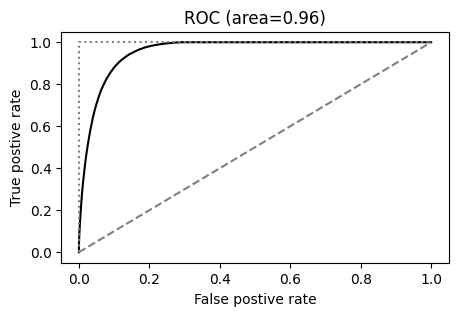

In [100]:
MyEvaluate.plot_roc(pred_test)

In [101]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_cys.pth')